In [125]:
from lxml import etree
import re
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
%matplotlib inline

In [139]:
class Text(): 
    def __init__(self, filename): 
        self.tree = etree.parse(filename)
        saidElems = self.tree.findall('.//said[@who]')
        self.allChars = [elem.attrib['who'] for elem in saidElems]
        self.chars = list(set(self.allChars))
        self.labeledText = [(elem.attrib['who'], elem.text) for elem in saidElems]
        self.labeledText = [(item[0], self.clean(item[1])) for item in self.labeledText]
        self.labels = [item[0] for item in self.labeledText]
        self.allText = [item[1] for item in self.labeledText]
        
    def clean(self, utterance): 
        """ 
        Cleans utterances. 
        """
        # Remove "said Bernard," etc. 
        charRegex = "said (%s)," % '|'.join(self.chars)
        out = re.sub(charRegex, '', utterance)
       
        # Remove quotation marks. 
        out = re.sub('[“”"]', '', out)
        
        # Remove line breaks. 
        out = re.sub('\n', ' ', out)
        return out

In [140]:
t = Text('waves-tei.xml')

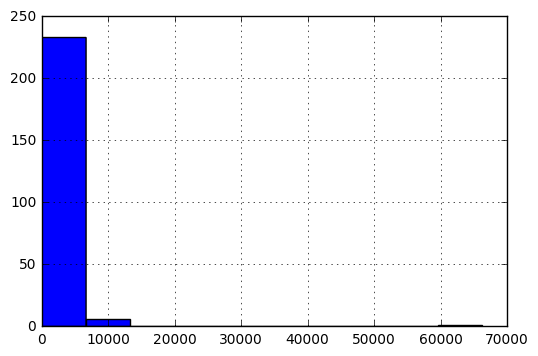

In [141]:
lens = [len(utterance) for utterance in t.allText]
pd.Series(lens).hist()

In [142]:
docs = t.allText

In [143]:
tfidf_vectorizer = TfidfVectorizer()

In [144]:
tfidfs = tfidf_vectorizer.fit_transform(docs).todense()

In [145]:
df = pd.DataFrame(tfidfs, columns=tfidf_vectorizer.get_feature_names())

In [146]:
# Do latent semantic analysis dimensionality reduction. 
svd = TruncatedSVD()
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [147]:
lsa_out = lsa.fit_transform(df)

In [148]:
lsaDF = pd.DataFrame(lsa_out, columns=['x','y'])

In [150]:
lsaDF['label'] = t.labels

In [151]:
lsaDF

,x,y,label
0,0.988892,-0.148639,Bernard
1,0.999155,-0.041108,Susan
2,0.908645,-0.417569,Rhoda
3,0.936538,-0.350565,Neville
4,0.996598,0.082419,Jinny
5,0.965206,-0.261491,Louis
6,0.898064,-0.439865,Bernard
7,0.759143,-0.650923,Susan
8,0.777375,-0.629037,Louis
9,0.793640,-0.608388,Rhoda


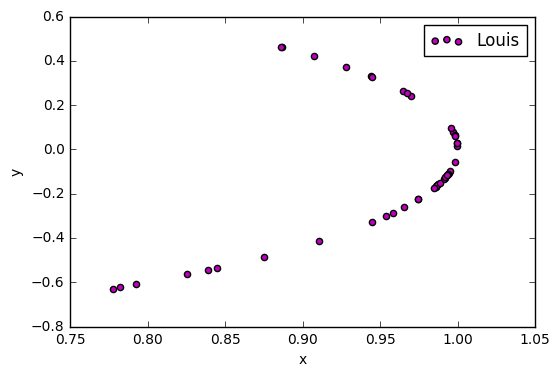

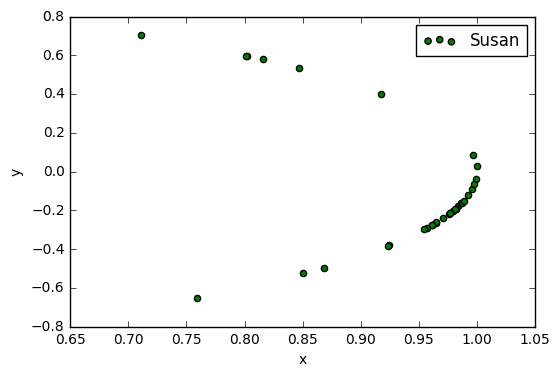

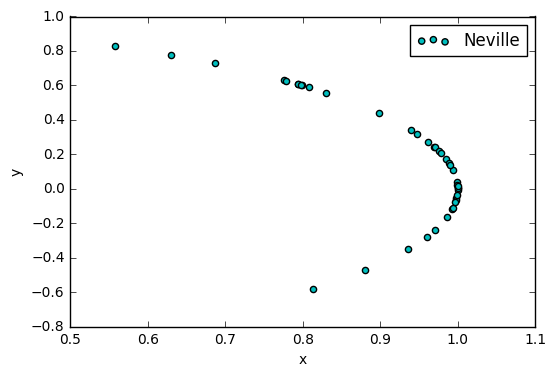

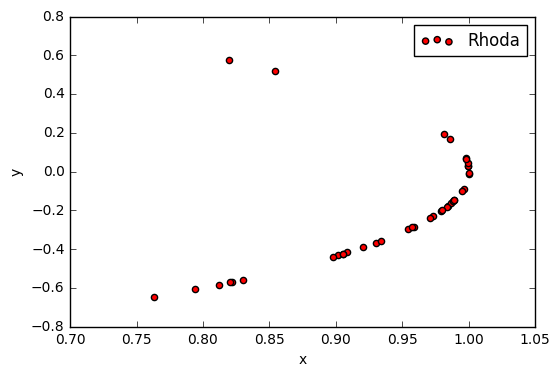

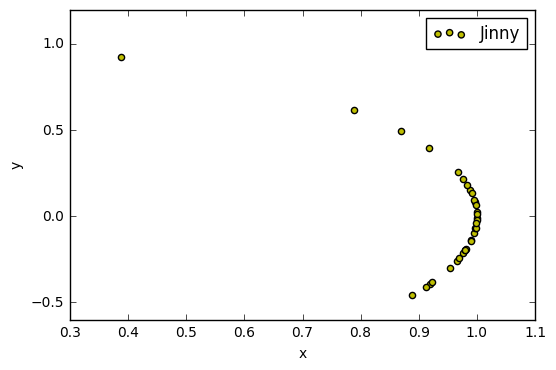

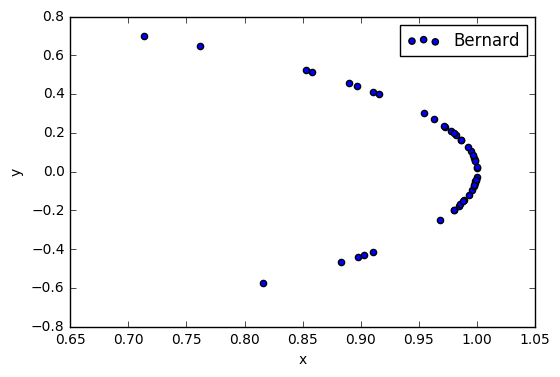

In [186]:
ax = None
for char in t.chars: 
    charDF = lsaDF.loc[lsaDF['label'] == char]
    if ax is None: 
        charDF.plot(kind='scatter', x='x', y='y', color=translateColor(char), label=char)
    else: 
        ax.plot(kind='scatter', x='x', y='y', color=translateColor(char), label=char)

In [162]:
def translateColor(label): 
    colorDict = {'B': 'b', 'S': 'g', 'R': 'r', 'N': 'c', 'J': 'y', 'L': 'm'}
    return colorDict[label[0]]

In [163]:
lsaDF['colors'] = lsaDF['label'].apply(translateColor)

ValueError: to_rgba: Invalid rgba arg "colors"
to_rgb: Invalid rgb arg "colors"
could not convert string to float: 'colors'

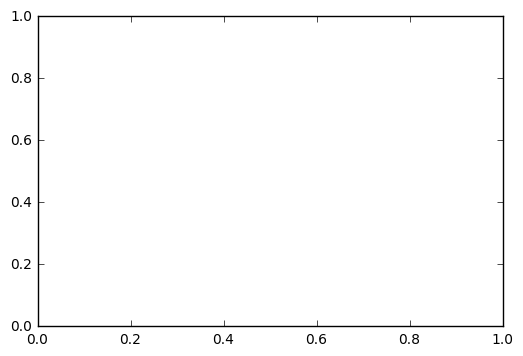

In [167]:
lsaDF.plot(kind='scatter', x='x', y='y', color='colors')